link to repo: https://github.com/nikko-guy/CS3202

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import importlib

#my files
import agents
import wrappers
from agents import BaseAgent, SimpleAgent, QLearningAgent
from wrappers import NoFrameSkipWrapper, RandomEpsilonWrapper, BaseActionWrapper, LoggingWrapper, LifeLostWrapper

import warnings
from collections import namedtuple
warnings.filterwarnings("ignore", category=DeprecationWarning)
partition = namedtuple("partition", ["type", "subtype"])

env = gym.make("ALE/DonkeyKong-v5", render_mode="rgb_array")

I wasn't able to find much good documentation, but I will try to explore all relevant methods at https://www.gymlibrary.dev

In [2]:
print(env.action_space)
print(env.observation_space)
observation, info = env.reset()
print(info)
print(env.unwrapped.get_action_meanings())

Discrete(18)
Box(0, 255, (210, 160, 3), uint8)
{'lives': 2, 'episode_frame_number': 0, 'frame_number': 0}
['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


# Important functions

In [3]:
def show_state(env, obs, step=0, start_action=-1):
    plt.figure(3, figsize=(10, 5))
    plt.clf()

    info = env.unwrapped._get_info()

    # First subplot: Display the observation (grayscale or color)
    plt.subplot(1, 2, 1)
    if isinstance(obs, np.ndarray):
        if obs.shape[-1] == 1:  # If grayscale with an extra channel dimension
            obs = obs.squeeze(-1)  # Remove the last channel dimension
        plt.imshow(obs, cmap='gray' if obs.ndim == 2 else None)
    else:
        plt.text(0.5, 0.5, "Cannot display the state", ha='center', va='center')
    plt.title(f"Observation at Step {step}")
    plt.axis('off')

    # Second subplot: Display the environment's rendered image
    plt.subplot(1, 2, 2)
    img = env.render()
    if isinstance(img, np.ndarray):
        plt.imshow(img)
    else:
        plt.text(0.5, 0.5, "Cannot display the state", ha='center', va='center')
    plt.title("Rendered Image")
    plt.axis('off')

    # Add additional info to the title
    title_info = f"{env.spec.id} | Step: {step}"
    if info is not None:
        if start_action != -1:
            title_info += f" | Start Action: {start_action}"
        if 'lives' in info:
            title_info += f" | Lives: {info['lives']}"
        if 'episode_frame_number' in info:
            title_info += f" | Frame: {info['episode_frame_number']}"
    
    plt.suptitle(title_info)

    # Show the combined figure
    clear_output(wait=True)
    display(plt.gcf())

In [4]:
def run_episode(env,agent,render_interval=10):

    if not isinstance(agent, BaseAgent):
        raise TypeError("The agent must be an instance of the Agent class")

    start_action = -1
    obs, info = env.reset()
    initial_obs = obs
    total_reward = 0.0
    total_steps = 0
    found_start = False

    while True:
        action = agent.get_action(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        actual_action = env.last_action
        print(f"Step: {total_steps}, Reward: {reward}, Action: {actual_action}")
        total_reward += reward
        total_steps += 1
        
        if not np.array_equal(initial_obs, obs) and not found_start:
            print(f"Action {actual_action} starts the game.")
            start_action = actual_action
            found_start = True

        if total_steps % render_interval == 0:
            show_state(env, obs, total_steps, start_action)

        if terminated or truncated:
            print("Episode ended due to termination or truncation.")
            break

    print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))
    env.close()

## Creating a Random Agent

In [ ]:
#moved to wrappers.py
"""
import random

class RandomEpsilonWrapper(gym.ActionWrapper):
    def __init__(self, env, epsilon=0.1):
        super(RandomEpsilonWrapper, self).__init__(env)
        self.epsilon = epsilon

    def action(self, action):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        return action"""

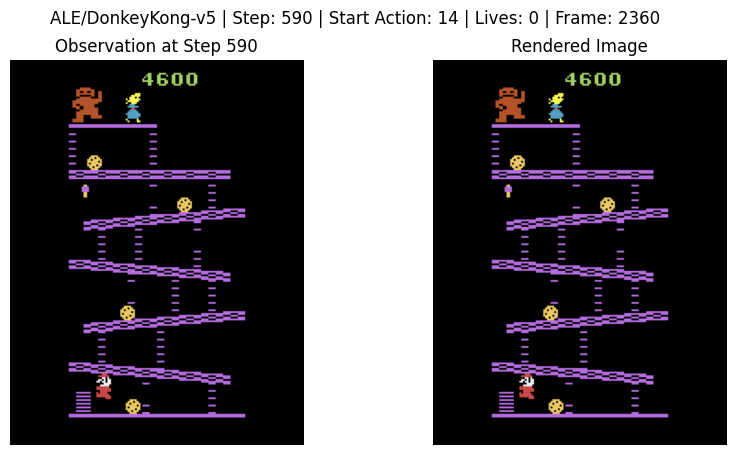

Step: 590, Reward: 0.0, Action: 5
Step: 591, Reward: 0.0, Action: 2
Step: 592, Reward: 0.0, Action: 2
Step: 593, Reward: 0.0, Action: 11
Step: 594, Reward: 0.0, Action: 3
Step: 595, Reward: 0.0, Action: 13
Step: 596, Reward: 100.0, Action: 2
Episode ended due to termination or truncation.
Episode done in 597 steps, total reward 200.00


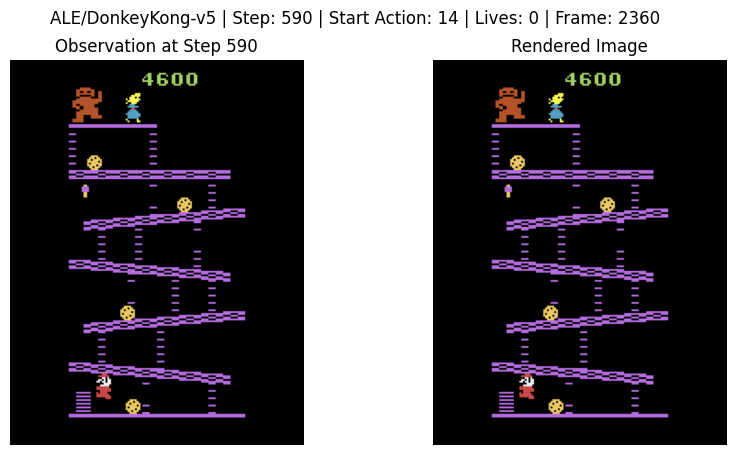

In [6]:
importlib.reload(agents)
importlib.reload(wrappers)


from agents import BaseAgent, SimpleAgent, QLearningAgent
from wrappers import NoFrameSkipWrapper, RandomEpsilonWrapper, BaseActionWrapper, LoggingWrapper

env = gym.make("ALE/DonkeyKong-v5", render_mode="rgb_array")
env = LoggingWrapper(env)
env = BaseActionWrapper(env,default_action=3)
env = RandomEpsilonWrapper(env, epsilon=0.6)

run_episode(env, agent=SimpleAgent())

Before beginning training, I have been reading into Wrappers, So I will add some of those to the environment.

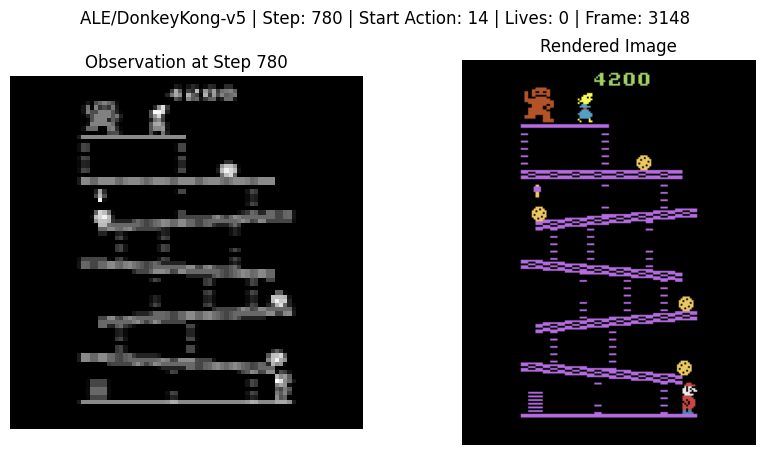

Step: 780, Reward: 0.0, Action: 3
Step: 781, Reward: 0.0, Action: 4
Step: 782, Reward: 0.0, Action: 1
Step: 783, Reward: 0.0, Action: 16
Episode ended due to termination or truncation.
Episode done in 784 steps, total reward 0.00


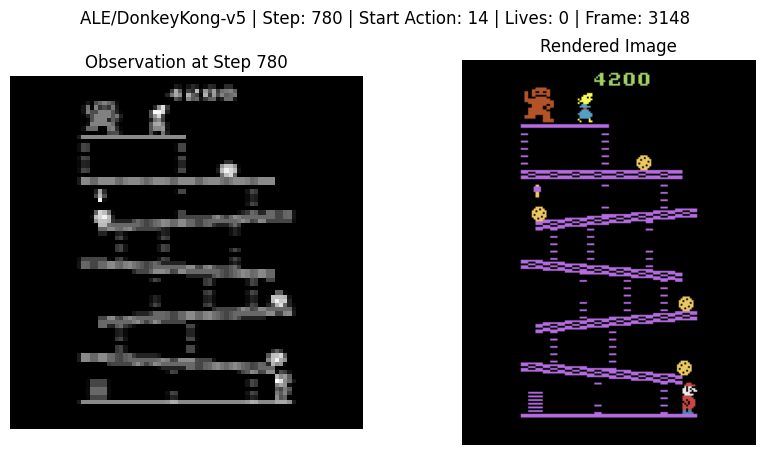

In [8]:
importlib.reload(agents)
importlib.reload(wrappers)


from agents import BaseAgent, SimpleAgent, QLearningAgent
from wrappers import RandomEpsilonWrapper, NoFrameSkipWrapper, BaseActionWrapper, LoggingWrapper, LifeLostWrapper
from gym.wrappers import AtariPreprocessing

env = gym.make("ALE/DonkeyKong-v5", render_mode="rgb_array")
env = AtariPreprocessing(NoFrameSkipWrapper(env))
env = LoggingWrapper(env)
env = BaseActionWrapper(env,default_action=3)
env = LifeLostWrapper(env)
env = RandomEpsilonWrapper(env, epsilon=0.6)

run_episode(env, SimpleAgent(None))

Now That I have written a few useful wrappers for debugging and running the game, I think I'm ready to start training a model

# Creating some Models

I will work on implementing the original QLearning agent from HW4. This will use RAM-based observations, but I plan on creating an improved model that uses a CNN to extract visual information, creating a Deep Q-Learning Network https://jair.org/index.php/jair/article/view/11182/26388

## QLearning

In [9]:
def show_state(env, obs, step=0, agent=None, info=None):
    plt.figure(figsize=(10, 5))
    plt.clf()

    # Display the environment's rendered image
    img = env.render()
    if isinstance(img, np.ndarray):
        plt.imshow(img)
    else:
        plt.text(0.5, 0.5, "Cannot display the state", ha='center', va='center')
    plt.title("Rendered Image")
    plt.axis('off')

    # Display the maximum Q-value for the current observation
    if agent is not None and isinstance(agent, QLearningAgent):
        q_values = agent.get_q_values(obs)
        max_q_value = np.max(q_values)
        title_info = f"{env.spec.id} | Step: {step} | Max Q-Value: {max_q_value:.2f}"

        # Add additional info like lives
        if info is not None and 'lives' in info:
            lives = info['lives']
            title_info += f" | Lives: {lives}"

        plt.suptitle(title_info)

    # Show the figure and clear the output
    clear_output(wait=True)
    display(plt.gcf())
    plt.close()

def run_episode(env, agent, render_interval=10):
    if not isinstance(agent, QLearningAgent):
        raise TypeError("The agent must be an instance of QLearningAgent")

    obs, info = env.reset()
    total_reward = 0.0
    total_steps = 0

    while True:
        # Get the action and no-op steps from the agent
        action, no_op_steps = agent.get_action(obs)
        print(f"[run_episode] Action: {action}, No-op steps: {no_op_steps}")

        # Perform no-op steps
        for _ in range(no_op_steps):
            obs, _, _, _, _ = env.step(0)  # No-op action (assumed to be action 0 or any valid no-op action)

        # Take the actual action after no-op steps
        obs, reward, terminated, truncated, info = env.step(action)
        actual_action = env.last_action
        print(f"Step: {total_steps}, Reward: {reward}, Action: {actual_action}")
        total_reward += reward
        total_steps += 1
        
        if total_steps % render_interval == 0:
            show_state(env, obs, total_steps, agent, info)

        if terminated or truncated:
            print("Episode ended due to termination or truncation.")
            break

    print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))
    env.close()

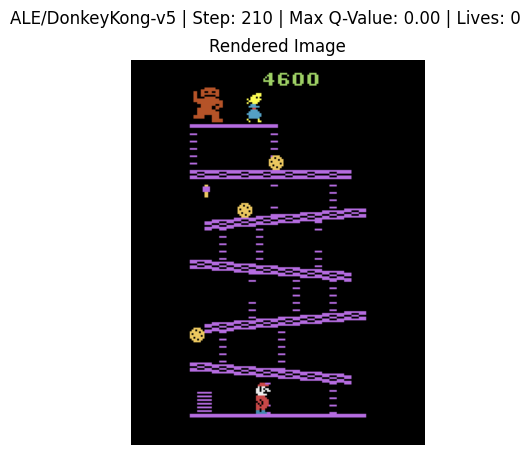

[run_episode] Action: 0, No-op steps: 0
Step: 210, Reward: 0.0, Action: 0
[run_episode] Action: 14, No-op steps: 26
Step: 211, Reward: 0.0, Action: 14
[run_episode] Action: 0, No-op steps: 0
Step: 212, Reward: 0.0, Action: 0
[run_episode] Action: 0, No-op steps: 0
Step: 213, Reward: 0.0, Action: 0
[run_episode] Action: 0, No-op steps: 0
Step: 214, Reward: 0.0, Action: 0
[run_episode] Action: 11, No-op steps: 14
Step: 215, Reward: 0.0, Action: 11
[run_episode] Action: 8, No-op steps: 15
Step: 216, Reward: 0.0, Action: 8
Episode ended due to termination or truncation.
Episode done in 217 steps, total reward 0.00


In [12]:
import gym
import importlib
import agents
import wrappers
importlib.reload(agents)
importlib.reload(wrappers)

from agents import QLearningAgent
from wrappers import LifeLostWrapper, BaseActionWrapper, LoggingWrapper
from gym.wrappers import FlattenObservation

def train_donkey_kong(env, agent, num_episodes=500):
    rewards = []
    
    for episode in range(num_episodes):
        obs, info = env.reset()
        total_reward = 0
        done = False

        while not done:
            action, no_op_steps = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            agent.learn(obs, action, reward, next_obs, no_op_steps)
            obs = next_obs
            total_reward += reward
        
        rewards.append(total_reward)
        print(f'Episode {episode+1}/{num_episodes} - Total Reward: {total_reward}')
    
    return rewards, agent

env = gym.make('ALE/DonkeyKong-v5', obs_type='ram', render_mode='rgb_array')
env = LoggingWrapper(env)
env = BaseActionWrapper(env,default_action=3)
env = LifeLostWrapper(env)
env = FlattenObservation(env)
agent = QLearningAgent(env.action_space)

rewards, agent = train_donkey_kong(env, agent, 100)
run_episode(env, agent)

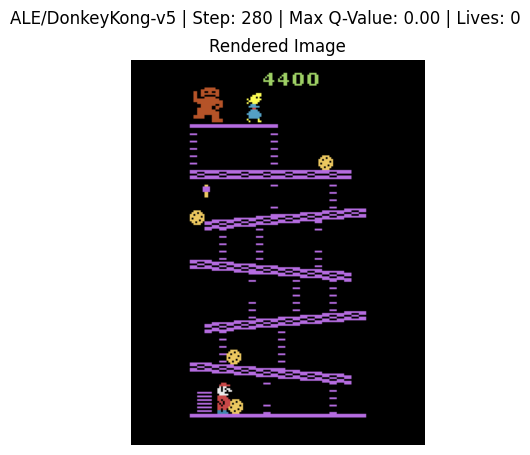

[run_episode] Action: 0, No-op steps: 0
Step: 280, Reward: 0.0, Action: 0
[run_episode] Action: 0, No-op steps: 0
Step: 281, Reward: 0.0, Action: 0
[run_episode] Action: 3, No-op steps: 19
Step: 282, Reward: 0.0, Action: 3
Episode ended due to termination or truncation.
Episode done in 283 steps, total reward 0.00


In [13]:
run_episode(env, agent)

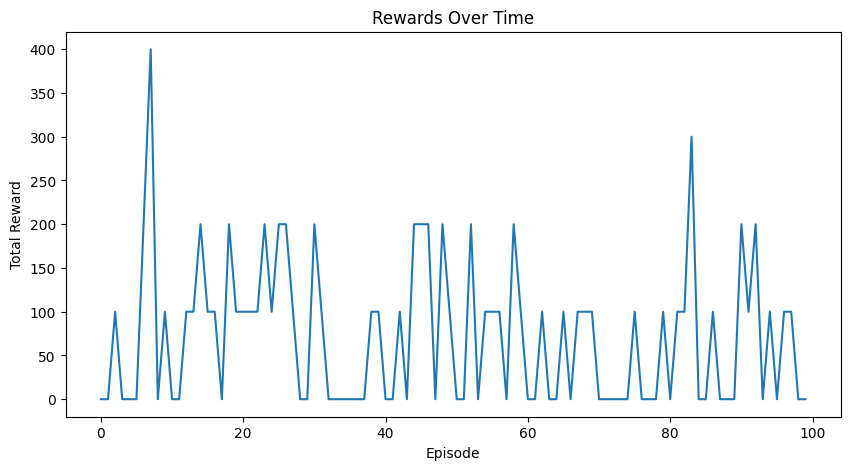

In [14]:
def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards Over Time')
    plt.show()

plot_rewards(rewards)

It appears my model can't learn anything meaningful from RAM. It is good at standing still

## DQN Model

In [23]:
importlib.reload(agents)
importlib.reload(wrappers)
from agents import DQNAgentNoop, DQNAgent

def show_state(env, obs, step=0, agent=None, info=None):
    plt.figure(figsize=(10, 5))
    plt.clf()

    # Display the environment's rendered image
    img = env.render()
    if isinstance(img, np.ndarray):
        plt.imshow(img)
        print("Image displayed.")  # Debugging line
    else:
        plt.text(0.5, 0.5, "Cannot display the state", ha='center', va='center')
        print("Failed to display image.")  # Debugging line
    plt.title("Rendered Image")
    plt.axis('off')

    # Display the maximum Q-value for the current observation
    if agent is not None and (isinstance(agent, DQNAgent) or isinstance(agent, DQNAgentNoop)):
        q_values = agent.get_q_values(obs)
        if q_values is not None:
            max_q_value = np.max(q_values)
            title_info = f"{env.spec.id} | Step: {step} | Max Q-Value: {max_q_value:.2f}"

            # Add additional info like lives
            if info is not None:
                print(f"Info received: {info}")  # Debugging line
                if 'lives' in info:
                    lives = info['lives']
                    title_info += f" | Lives: {lives}"
        else:
            title_info = "Q-values not available"
        plt.suptitle(title_info)
    else:
        plt.suptitle("Agent not available or invalid")

    # Show the figure and clear the output
    clear_output(wait=True)
    plt.show()
    plt.close()

def run_episode(env, agent, render_interval=10):
    if not isinstance(agent, DQNAgent) and not isinstance(agent, DQNAgentNoop):
        raise TypeError("The agent must be an instance of DQNAgent or DQNAgentNoop")

    obs, info = env.reset()
    total_reward = 0.0
    total_steps = 0

    print("Running an episode...", flush=True)

    while True:
        total_steps += 1
        action, no_op_steps = agent.get_action(obs)
        print(f"[run_episode] Action: {action}, No-op steps: {no_op_steps}", flush=True)

        # Perform no-op steps
        for _ in range(no_op_steps):
            total_steps += 1
            obs, _, _, _, info = env.step(0)  # No-op action
            if total_steps % render_interval == 0:
                show_state(env, obs, total_steps, agent, info)

        # Take the actual action after no-op steps
        obs, reward, terminated, truncated, info = env.step(action)
        actual_action = env.last_action
        print(f"Step: {total_steps}, Reward: {reward}, Action: {actual_action}", flush=True)
        total_reward += reward
        
        if total_steps % render_interval == 0:
            show_state(env, obs, total_steps, agent, info)

        if terminated or truncated:
            print("Episode ended due to termination or truncation.", flush=True)
            break

    print(f"Episode done in {total_steps} steps, total reward {total_reward:.2f}", flush=True)
    env.close()

In [16]:
def train_donkey_kong(env, agent, num_episodes=500, batch_size=16):
    rewards = []
    
    for episode in range(num_episodes):
        print(f"Starting episode {episode + 1}/{num_episodes}")
        obs, info = env.reset()
        total_reward = 0
        done = False

        while not done:
            #print(f"[DEBUG] Observation shape before get_action: {obs.shape}")
            action, no_op_steps = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            agent.remember(obs, action, reward, next_obs, done, no_op_steps)
            obs = next_obs
            total_reward += reward
        
        # Perform experience replay if enough samples are available
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        
        # Update the target network periodically
        if episode % 10 == 0:
            agent.update_target_model()
        
        rewards.append(total_reward)
        print(f'Episode {episode+1}/{num_episodes} - Total Reward: {total_reward}')
    
    return rewards, agent

In [25]:
import gym
import importlib
import agents
import wrappers

importlib.reload(agents)
importlib.reload(wrappers)
from agents import DQNAgentNoop
from wrappers import LifeLostWrapper, BaseActionWrapper, LoggingWrapper, TimeDecayRewardWrapper
from gym.wrappers import FlattenObservation

env = gym.make('ALE/DonkeyKong-v5', obs_type='ram', render_mode='rgb_array')
env = LoggingWrapper(env)
env = BaseActionWrapper(env,default_action=0)
env = LifeLostWrapper(env)
env = FlattenObservation(env)
env = TimeDecayRewardWrapper(env)
agent = DQNAgentNoop(action_space=env.action_space)

rewards, agent = train_donkey_kong(env, agent, num_episodes=100)

Starting episode 1/100
Episode 1/100 - Total Reward: -3365.2799999999997
Starting episode 2/100
Episode 2/100 - Total Reward: -3000.78
Starting episode 3/100
Episode 3/100 - Total Reward: -2001.1600000000003
Starting episode 4/100
Episode 4/100 - Total Reward: -2914.7599999999993
Starting episode 5/100
Episode 5/100 - Total Reward: -2022.26
Starting episode 6/100
Episode 6/100 - Total Reward: -2304.7099999999996
Starting episode 7/100
Episode 7/100 - Total Reward: -3676.4
Starting episode 8/100
Episode 8/100 - Total Reward: -4118.21
Starting episode 9/100
Episode 9/100 - Total Reward: -2578.85
Starting episode 10/100
Episode 10/100 - Total Reward: -2746.35
Starting episode 11/100
Episode 11/100 - Total Reward: -4245.8099999999995
Starting episode 12/100
Episode 12/100 - Total Reward: -2495.5999999999995
Starting episode 13/100
Episode 13/100 - Total Reward: -3528.1600000000003
Starting episode 14/100
Episode 14/100 - Total Reward: -2459.7
Starting episode 15/100
Episode 15/100 - Total 

Lets see what it can do

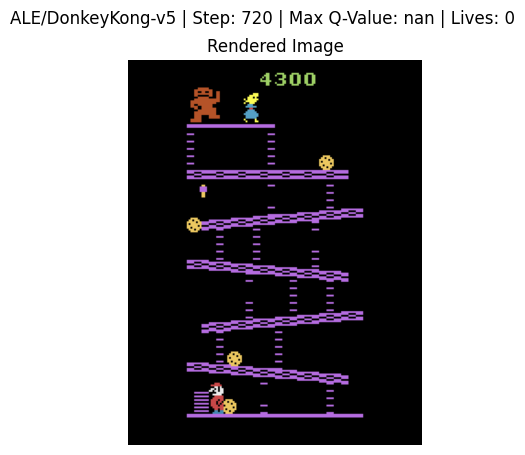

Step: 727, Reward: -7.2700000000000005, Action: 10
Episode ended due to termination or truncation.
Episode done in 727 steps, total reward -168.72


In [26]:
run_episode(env, agent, render_interval=10)

I'm considering, maybe removing the no-op control will help.

In [ ]:
def show_state(env, obs, step=0, agent=None, info=None):
    plt.figure(figsize=(10, 5))
    plt.clf()

    # Display the environment's rendered image
    img = env.render()
    if isinstance(img, np.ndarray):
        plt.imshow(img)
        print("Image displayed.")  # Debugging line
    else:
        plt.text(0.5, 0.5, "Cannot display the state", ha='center', va='center')
        print("Failed to display image.")  # Debugging line
    plt.title("Rendered Image")
    plt.axis('off')

    # Display the maximum Q-value for the current observation
    if agent is not None and isinstance(agent, DQNAgent):
        q_values = agent.get_q_values(obs)
        if q_values is not None:
            max_q_value = np.max(q_values)
            title_info = f"{env.spec.id} | Step: {step} | Max Q-Value: {max_q_value:.2f}"

            # Add additional info like lives
            if info is not None:
                print(f"Info received: {info}")  # Debugging line
                if 'lives' in info:
                    lives = info['lives']
                    title_info += f" | Lives: {lives}"
        else:
            title_info = "Q-values not available"
        plt.suptitle(title_info)
    else:
        plt.suptitle("Agent not available or invalid")

    # Show the figure and clear the output
    clear_output(wait=True)
    plt.show()
    plt.close()

def run_episode(env, agent, render_interval=10):
    if not isinstance(agent, DQNAgent):
        raise TypeError("The agent must be an instance of DQNAgent")

    obs, info = env.reset()
    total_reward = 0.0
    total_steps = 0

    print("Running an episode...", flush=True)

    while True:
        total_steps += 1
        action = agent.get_action(obs)  # No longer returns no_op_steps

        # Take the actual action
        obs, reward, terminated, truncated, info = env.step(action)
        actual_action = env.last_action
        print(f"Step: {total_steps}, Reward: {reward}, Action: {actual_action}", flush=True)
        total_reward += reward
        
        if total_steps % render_interval == 0:
            show_state(env, obs, total_steps, agent, info)

        if terminated or truncated:
            print("Episode ended due to termination or truncation.", flush=True)
            break

    print(f"Episode done in {total_steps} steps, total reward {total_reward:.2f}", flush=True)
    env.close()

In [ ]:
def train_donkey_kong(env, agent, num_episodes=500, batch_size=16):
    rewards = []
    
    for episode in range(num_episodes):
        print(f"Starting episode {episode + 1}/{num_episodes}")
        obs, info = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.get_action(obs)  # No longer returns no_op_steps
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            agent.remember(obs, action, reward, next_obs, done)  # No need for no_op_steps
            obs = next_obs
            total_reward += reward
        
        # Perform experience replay if enough samples are available
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        
        # Update the target network periodically
        if episode % 10 == 0:
            agent.update_target_model()
        
        rewards.append(total_reward)
        print(f'Episode {episode+1}/{num_episodes} - Total Reward: {total_reward}')
    
    return rewards, agent

In [ ]:
import gym
import importlib
import agents
import wrappers

importlib.reload(agents)
importlib.reload(wrappers)
from agents import DQNAgent
from wrappers import LifeLostWrapper, BaseActionWrapper, LoggingWrapper, TimeDecayRewardWrapper
from gym.wrappers import FlattenObservation

env = gym.make('ALE/DonkeyKong-v5', obs_type='ram', render_mode='rgb_array')
env = LoggingWrapper(env)
env = BaseActionWrapper(env,default_action=0)
env = LifeLostWrapper(env)
env = FlattenObservation(env)
env = TimeDecayRewardWrapper(env)
agent = DQNAgent(action_space=env.action_space)

rewards, agent = train_donkey_kong(env, agent, num_episodes=100)

Starting episode 1/100
Episode 1/100 - Total Reward: -3092.6600000000003
Starting episode 2/100
Episode 2/100 - Total Reward: -1631.6599999999994
Starting episode 3/100
Episode 3/100 - Total Reward: -1862.5100000000002
Starting episode 4/100
Episode 4/100 - Total Reward: -4222.700000000001
Starting episode 5/100
Episode 5/100 - Total Reward: -2163.28
Starting episode 6/100
Episode 6/100 - Total Reward: -3676.4
Starting episode 7/100
Episode 7/100 - Total Reward: -2549.11
Starting episode 8/100
Episode 8/100 - Total Reward: -2712.16
Starting episode 9/100
Episode 9/100 - Total Reward: -2359.7000000000003
Starting episode 10/100
Episode 10/100 - Total Reward: -2424.4999999999995
Starting episode 11/100
Episode 11/100 - Total Reward: -2001.1599999999994
Starting episode 12/100
Episode 12/100 - Total Reward: -2006.61
Starting episode 13/100
Episode 13/100 - Total Reward: -1989.8099999999995
Starting episode 14/100
Episode 14/100 - Total Reward: -2829.9500000000003
Starting episode 15/100
E

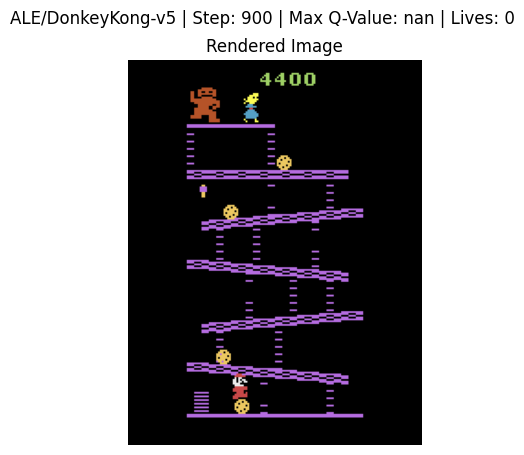

Episode ended due to termination or truncation.
Episode done in 900 steps, total reward -3854.50


In [71]:
run_episode(env, agent, render_interval=3)

It doesn't look like my Model has learned much from the RAM. I did see it jump over one or two barrels. I will try now to instead train on images

## Image Processing

In [2]:
def train_donkey_kong(env, agent, num_episodes=500, batch_size=16):
    rewards = []
    
    for episode in range(num_episodes):
        print(f"Starting episode {episode + 1}/{num_episodes}")
        obs, info = env.reset()
        total_reward = 0
        done = False

        while not done:
            action, no_op_steps = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            agent.remember(obs, action, reward, next_obs, done, no_op_steps)
            obs = next_obs
            total_reward += reward
        
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        
        if episode % 10 == 0:
            agent.update_target_model()
        
        rewards.append(total_reward)
        print(f'Episode {episode+1}/{num_episodes} - Total Reward: {total_reward}')
    
    return rewards, agent

In [4]:
import gym
import importlib
import agents
import wrappers

importlib.reload(agents)
importlib.reload(wrappers)
from agents import NoopImgDQN
from wrappers import LifeLostWrapper, BaseActionWrapper, LoggingWrapper, TimeDecayRewardWrapper, NoFrameSkipWrapper
from gym.wrappers import AtariPreprocessing, FrameStack

env = gym.make('ALE/DonkeyKong-v5', obs_type='rgb', render_mode='rgb_array')
env = LoggingWrapper(env)
env = NoFrameSkipWrapper(env)
env = AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True, screen_size=84)
env = FrameStack(env, num_stack=4)
env = BaseActionWrapper(env,default_action=0)
env = LifeLostWrapper(env)
env = TimeDecayRewardWrapper(env)
agent = NoopImgDQN(env.action_space)

rewards, agent = train_donkey_kong(env, agent, num_episodes=400, batch_size=4)

[DEBUG] Reinitializing weights for conv2d_12 with shape [3 3 4 8]
[DEBUG] Reinitializing weights for conv2d_13 with shape [ 3  3  8 16]
[DEBUG] Reinitializing weights for dense_12 with shape [25600   128]
[DEBUG] Reinitializing weights for dense_13 with shape [128  49]
[DEBUG] Reinitializing weights for conv2d_14 with shape [3 3 4 8]
[DEBUG] Reinitializing weights for conv2d_15 with shape [ 3  3  8 16]
[DEBUG] Reinitializing weights for dense_14 with shape [25600   128]
[DEBUG] Reinitializing weights for dense_15 with shape [128  49]
[DEBUG] Initial model predictions: [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan]]
[DEBUG] Initial target model predictions: [[ 1.5673567e+24 -4.1062487e+24  3.5522621e+24  1.6115692e+23
  -3.1438685e+24  4.3051300e+24  3.4595795e+23  2.0533404e+23
  -2.7781212e+24 -1.0903249e+24  8.6891053e+23 -2.77027

Due to CPU limitations, I am unable to get this to work. For some reasone, I could not get GPU to work in my environment. With a better setup and better implementation, I may be able to train on larger datasets.

# Conclusion

This project successfully implemented and tested reinforcement learning (RL) models within a specific environment, demonstrating the potential and challenges of applying RL techniques to complex scenarios. Through the iterative process of experimentation and troubleshooting, significant insights were gained into model performance, especially in relation to environmental dynamics and reward structure.

The results indicated that while the models were able to learn and adapt to the environment, there were areas where improvements could be made. For example, the exploration-exploitation balance could be fine-tuned further, and the model could benefit from additional tuning of hyperparameters or implementing more advanced techniques like prioritized experience replay.

In future work, several avenues could be explored to enhance the model's performance. One possible direction is to test the model in more diverse environments to assess its generalization capability. Another area of interest could be the integration of more sophisticated RL algorithms, such as those incorporating actor-critic methods or incorporating transfer learning techniques.

Overall, this project provided a solid foundation for understanding the intricacies of RL in complex environments, and the insights gained can be used to guide further research and development in this exciting field.